# Data Science Portfolio: NLP Disaster Tweets

**Author:** Jasper Sylvestre  
**Date:** March 13th, 2024

**Description:** This notebook showcases NLP and modeling BiLSTM architecture using the data available on __[Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data)__. A summary and list of conclusions are provided at the end.

**Version:** 1.0  
**Dependencies:**
- python 3.12.2
- ipykernel 6.29.3
- ipython 8.22.1
- jupyter_client 8.6.0
- jupyter_core 5.7.1
- matplotlib 3.8.3
- numpy 1.26.4
- pandas 2.2.0
- scikit-learn 1.4.1.post1
- scipy 1.12.0
- seaborn 0.13.2
- spacy 3.7.4
- torch 2.2.0
- torchdata 0.7.1
- tqdm 4.66.2

**Acknowledgments:**  
- Datasets provided by Addison Howard, devrishi, Phil Culliton, and Yufeng Guo.
- Inspired by the code from Kaggle user @OmarioVIC found __[here](https://www.kaggle.com/code/omariovic/nlp-disasters-predictions-with-pytorch)__.

**License:** MIT License  
**Contact:** jesylvestre0@gmail.com

# Introduction

This Jupyter notebook aims to predict whether or not Tweets correspond to real disasters or not. This will involve forming a submission CSV file with `id` values corresponding to predicted `target` values. The F1 score of the model is the metric being used on the Kaggle page and is the metric we will use here primarily to evaluate the models.

The datasets used for modeling in this notebook can be found __[here](https://www.kaggle.com/competitions/nlp-getting-started/dataet)__ and was found on Kaggle. We will begin by importing necessary libraries to conduct data science and machine learning procedures for natural language processing (NLP) and neural networks.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import re
import spacy
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    accuracy_score,
    matthews_corrcoef,
    cohen_kappa_score,
)
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Reading in the Data and Initial Inspection

We will import the datasets that are in the CSV format and are in the "data" folder, with separate testing and training datasets. The target values indicate whether a Tweet corresponds to a real disaster, denoted by a 1, and 0 if not. There is no given target column in the testing dataset, and we will try to predict these values for the testing dataset later on. `id` will be kept for the testing dataset since we will need it for the submission CSV file.

We will only predict given the text variable as a predictor. Some of the data can be seen. The target values seem to be somewhat balanced for the training dataset. Upon inspection, the datatypes seem to be correct. The datasets seem to be ready for data cleaning.

In [2]:
# Read data
train_path = "../data/train.csv"
train_df = pd.read_csv(train_path)[["text", "target"]]

test_path = "../data/test.csv"
test_df = pd.read_csv(test_path)[["id", "text"]]

# Examine data
display(train_df.head(5))
train_df.info()

display(test_df.head(5))
test_df.info()

print("Target values for the training dataset.")
display(train_df["target"].value_counts())

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB
Target values for the training dataset.


target
0    4342
1    3271
Name: count, dtype: int64

# Data Cleaning

We will check for duplicate values, and we can find 92 duplicate observations across `text` and `target` columns. We will remove these observations from the training dataset. Past that, we will check for duplicate observations across the text column with contradictory `target` values. We can find 36 of these observations, which are problematic for training. We will remove these observations as well.

We will check for missing variables and can see there are none in the training dataset. Now we will move onto text processing to further prepare the data for modeling.

In [3]:
# Show duplicate count
print(f"There are {train_df.duplicated().sum()} duplicate entries across all variables.")

# Remove these duplicates
train_df_remove_duplicates = train_df.drop_duplicates()
train_df_remove_duplicates

# Show non-unique values across the text column with contradictory target values
non_unique_values = train_df_remove_duplicates[train_df_remove_duplicates.duplicated(subset=["text"], keep=False)].sort_values(by="text")
print(f"There are {len(non_unique_values)} duplicate observations across the `text` column with contradictory `target` values.")
display(non_unique_values.head(10))

# Remove observations with contradictory target values given the same text
train_df_cleaned = train_df_remove_duplicates.groupby("text").filter(lambda x: x["target"].nunique() == 1)

# Show missing values if there are any, otherwise show there are none
if len(train_df_cleaned) == len(train_df_cleaned.dropna()):
    print("There are no missing values in this dataset.")
else:
    print(f"There are {len(train_df_cleaned) - len(train_df_cleaned.dropna())} missing values in this dataset.")

There are 92 duplicate entries across all variables.
There are 36 duplicate observations across the `text` column with contradictory `target` values.


,text,target
4290,#Allah describes piling up #wealth thinking it...,0
4312,#Allah describes piling up #wealth thinking it...,1
4244,#foodscare #offers2go #NestleIndia slips into ...,0
4221,#foodscare #offers2go #NestleIndia slips into ...,1
2832,.POTUS #StrategicPatience is a strategy for #G...,0
2830,.POTUS #StrategicPatience is a strategy for #G...,1
4597,CLEARED:incident with injury:I-495 inner loop...,1
4618,CLEARED:incident with injury:I-495 inner loop...,0
4235,Caution: breathing may be hazardous to your he...,0
4232,Caution: breathing may be hazardous to your he...,1


There are no missing values in this dataset.


# Text Preprocessing

We will use the `en_core_web_lg` model in spaCy, a large English language model providing word vectors of size 300. These vectors encode semantic information necessary for a model to understand the Tweets.

We will make a function called `text_preprocess` to preprocess the text by handling empty strings, removing URLs, removing non-alphabetic characters, removing one-character words, and we can tokenize, lemmatize, and remove stop words, and then return the processed text.

We can see an example of the text preprocessing on some of the training data. We will then apply text preprocessing across all the text data for the training and testing datasets.

In [4]:
# Load English language model
nlp = spacy.load("en_core_web_lg")
VECTOR_SIZE = 300

In [5]:
# Define text preprocessing function
def text_preprocess(text: str) -> str:
    """
    Preprocesses the input text for NLP tasks.
    
    Args:
    - text (str): The input text to be preprocessed.
    
    Returns:
    - str: The preprocessed text.
    """
    # Handle empty string
    if not text:
        return ""
    
    # Remove URLs
    text = re.sub(r"https?://\S+", " ", text)
    
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    
    # Lowercase the text
    text = text.lower()
    
    # Remove one-character words
    text = " ".join(word for word in text.split() if len(word) > 1)
    
    # Tokenize, lemmatize, and remove stop words
    doc = nlp(text)
    processed_text = [token.lemma_ for token in doc if not token.is_stop]
    
    return " ".join(processed_text)

# Example of text preprocessing
display(train_df_cleaned["text"].head(10).apply(text_preprocess))

0                 deed reason earthquake allah forgive
1                forest fire near la ronge sask canada
2    resident ask shelter place notify officer evac...
3    people receive wildfire evacuation order calif...
4    get send photo ruby alaska smoke wildfire pour...
5    rockyfire update california hwy close directio...
6    flood disaster heavy rain cause flash flooding...
7                                       hill fire wood
8          emergency evacuation happen building street
9                             afraid tornado come area
Name: text, dtype: object

In [6]:
# Apply text preprocessing across entire text column

# For training dataset
train_df_cleaned["preprocessed_text"] = train_df_cleaned["text"].apply(text_preprocess)
display(train_df_cleaned[["text", "preprocessed_text"]])

# For testing dataset
test_df["preprocessed_text"] = test_df["text"].apply(text_preprocess)
display(test_df[["text", "preprocessed_text"]])

,text,preprocessed_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,get send photo ruby alaska smoke wildfire pour...
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,worldnews fall powerline link tram update fire...
7605,on the flip side I'm at Walmart and there is a...,flip walmart bomb evacuate stay tuned blow
7606,Suicide bomber kills 15 in Saudi security site...,suicide bomber kill saudi security site mosque...
7608,Two giant cranes holding a bridge collapse int...,giant crane hold bridge collapse nearby home


,text,preprocessed_text
0,Just happened a terrible car crash,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose flee street save
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan
...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fastener ...
3259,Storm in RI worse than last hurricane. My city...,storm ri bad hurricane city amp hard hit yard ...
3260,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo


# Converting Words to Numeric Vectors

We have determined that the maximum number of tokens across all preprocessed text observations in the training dataset is 21. Our goal is to convert each line of preprocessed text into an array of numeric vectors, effectively encoding semantic information into numeric form for modeling.

In instances where there are fewer than 21 tokens in the observation, we will pad the array with zero vectors. This approach ensures uniformity in the size of our arrays, which is necessary for modeling.

We will create a function called `word2vec` that employs a vector size of 300, as mentioned earlier, but it will be made to still work given a different input size if a different spaCy model were chosen. The final array shape will be 21 by 300, encorporating these two constants that will be inputs.

With this function, we will process all preprocessed text observations, further preparing the data for modeling with the training dataset and predicting with the testing dataset.

In [7]:
MAX_LEN = max(len(text.split()) for text in train_df_cleaned["preprocessed_text"])
print(f"Maximum number of tokens across all preprocessed text observations in the training dataset: {MAX_LEN}")

Maximum number of tokens across all preprocessed text observations in the training dataset: 21


In [8]:
def word2vec(text: str,
             vector_size: int,
             max_len: int) -> np.array(np.float64):
    """
    Convert text to numeric vectors using spaCy's NLP pipeline.
    
    Args:
    - text (str): Input text to be converted to numeric vectors.
    - vector_size (int): Size of the vector.
    - max_len (int): Size of maximum number of words in text.
    
    Returns:
    - np.ndarray(np.float64): Array of np.float64 vectors indicating numerically encoded semantic information.
    """
    # Process the text using spaCy's NLP pipeline
    doc = nlp(text)
    
    # Initialize a list to store numeric vectors
    num_vectors = []
    
    # Iterate over tokens in the processed document
    for token in doc:
        # Append the vector representation of each token to the list
        num_vectors.append(token.vector)
    
    # Pad num vectors with zero vectors if the length is less than max_len
    num_vectors += [[0] * vector_size for _ in range(max_len - len(num_vectors))]
    
    # Convert the list of num vectors to a numpy array
    num_vectors_array = np.array(num_vectors)
    
    return num_vectors_array

# Example of word2vec function
display(pd.DataFrame(word2vec(train_df_cleaned["preprocessed_text"][0], vector_size=VECTOR_SIZE, max_len=MAX_LEN)))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-2.52920,-2.29540,-2.14100,-3.44950,-0.13994,-0.78471,0.41509,-2.34060,0.464560,0.81966,...,1.0181,4.9255,3.47730,-0.73864,1.94370,0.91835,-0.62650,-2.93510,3.64080,-0.10550
1,-0.52097,3.73210,-0.56785,-0.99742,3.17980,1.70950,3.12540,4.95280,-3.320000,-1.51420,...,5.8541,-2.9473,0.51854,-0.61410,-2.77680,2.64960,2.69140,-1.65630,-2.19470,2.04470
2,-0.60911,-2.91400,-3.84390,-1.88390,1.23310,-0.73536,1.76360,2.75140,0.031006,0.09363,...,3.9088,-1.5697,2.67430,4.05320,-2.14300,2.99000,0.93813,-1.39700,0.58375,1.89850
3,0.37075,1.75860,-1.45970,3.69710,0.85235,-0.46995,-2.10470,1.10510,-0.324870,0.82496,...,1.1030,1.0051,-0.14496,-2.35320,-0.94861,1.52070,2.01340,-0.89644,1.29970,-0.92038
4,1.15700,-0.48182,-2.34630,-2.66910,-1.50260,3.71340,0.36540,0.56586,-0.370170,-0.38160,...,2.9691,-1.8302,1.18770,-1.59130,1.21540,-0.70313,0.20679,3.16780,-3.14600,0.80656
5,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,...,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


# Form Training, Validation, and Testing Data

We will be using the training dataset to form X and y tensors across training and validating tensors for modeling. We will use the testing dataset to form an X tensor that will be predicted on to for the submission predictions.

This will involve using the word to numeric vector function above to convert the preprocessed text into numeric vectors for modeling to populate X lists. The y arrays can be populated using the target values of the training dataset. We will convert the X lists into arrays. We can set a random seed for reproducability (this will be `123` for this notebook) for splitting the X and y arrays into correspodning training and validation arrays. 20% of the data will be used for validation and 80% will be used for training. We will keep track of the shapes of each array to make sure there are no errors later on related to shape.

We will convert the arrays into tensors. We will maintain keeping track of the shapes of these tensors.

Finally, we can convert these tensors into data loaders to be used for modeling and predicting. We will use a batch size of 64. We will maintain keeping track of the shapes with the data loaders.

In [9]:
# Make X variables
X = [] # For training and validation datasets
X_test = [] # For testing dataset

# Populate X with numeric vectors
for text in train_df_cleaned["preprocessed_text"]:
    X.append(word2vec(text, vector_size=VECTOR_SIZE, max_len=MAX_LEN))

# Populate X test with numeric vectors
for text in test_df["preprocessed_text"]:
    X_test.append(word2vec(text, vector_size=VECTOR_SIZE, max_len=MAX_LEN))

# Get y values and convert lists into arrays
X_np = np.array(X)
X_test_np = np.array(X_test)
y_np = train_df_cleaned["target"].values

# Keep track of shape of arrays
print(f"X shape: {X_np.shape} | Y Shape: {y_np.shape}")
print(f"X test shape: {X_test_np.shape}")

X shape: (7485, 21, 300) | Y Shape: (7485,)
X test shape: (3263, 21, 300)


In [10]:
# Set random seed for reproducability
RANDOM_SEED = 123
TEST_SIZE = 0.2

# Form training and validation datasets for X and y variables
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_np, y_np, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Keep track of shape of arrays
print("For NumPy arrays:")
print(f"X train shape: {X_train_np.shape} | X val shape: {X_val_np.shape}")
print(f"y train shape: | {y_train_np.shape} | y val shape: {y_val_np.shape}")

For NumPy arrays:
X train shape: (5988, 21, 300) | X val shape: (1497, 21, 300)
y train shape: | (5988,) | y val shape: (1497,)


In [11]:
# Convert NumPy arrays to tensors
X_train = torch.from_numpy(X_train_np.astype(np.float32))
X_val = torch.from_numpy(X_val_np.astype(np.float32))
y_train = torch.from_numpy(y_train_np.astype(np.int64))
y_val = torch.from_numpy(y_val_np.astype(np.int64))
X_test = torch.from_numpy(X_test_np.astype(np.float32))

# Keep track of shape of tensors
print("For Torch tensors:")
print(f"X train shape: {X_train.shape} | X val shape: {X_val.shape}")
print(f"y train shape: | {y_train.shape} | y val shape: {y_val.shape}")
print(f"X test shape: {X_test.shape}")

For Torch tensors:
X train shape: torch.Size([5988, 21, 300]) | X val shape: torch.Size([1497, 21, 300])
y train shape: | torch.Size([5988]) | y val shape: torch.Size([1497])
X test shape: torch.Size([3263, 21, 300])


In [12]:
# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Set batch size
BATCH_SIZE = 64

# Create data loaders
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE)

# Keep track of shape
print(f"Training data loader shape: {next(iter(train_loader))[0].shape}")
print(f"Validation data loader shape: {next(iter(val_loader))[0].shape}")

Training data loader shape: torch.Size([64, 21, 300])
Validation data loader shape: torch.Size([64, 21, 300])


# Creating the Model

We will implement a Bidirectional Long Short-Term Memory (BiLSTM) neural network model using PyTorch. This is an architecture common for sequence-based tasks like NLP. This will be done by implementing a class with input size, hidden size, and number of layers as arguments for initalization. We will also initialize the LSTM layer with these specified pararameters. The linear layer will be defined for classification purposes with double the hidden size as the input because it concatenates the forward and backward hidden states from the bidirectional LSTM. The output size will be 2 since this is binary classification.

The forward method defines how the data flows through the network during inference. It will take in the input, and the the hidden state and cell states will be set to zeros. The LSTM layer will process the input and return the output. The hidden state will be extracted from the output and passed through the linear layer to obtain final classification scores.

We will initialize two models using device-agnostic code using an input size of the vector size (300) mentioned previously, the hidden size will be 32, and the number of layers will be 5. One model will be used for when we train the model with a patience value of 1 and the other will be when we train the model with a patience value of 5.

For training purposes, we will select a criterion and optimizer. The criterion will be cross entropy loss, and the optimizer will be Adam with a learning rate of 0.0001. We will try to use 20 epochs.

In [13]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        
        # Linear layer for classification
        self.linear = nn.Linear(self.hidden_size * 2, 2)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out

In [14]:
# Find device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is found to be: '{device}'\n")

# Set model and optimizer hyperparameters
INPUT_SIZE = VECTOR_SIZE # 300
HIDDEN_SIZE = 32
NUM_LAYERS = 5
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20

# Initalize models
# Patience value of 2
model_1 = BiLSTM(INPUT_SIZE,
                 HIDDEN_SIZE,
                 NUM_LAYERS).to(device)
print(f"Model specifications for training with a patience value of 2: \n{model_1}\n")

# Patience value of 5
model_5 = BiLSTM(INPUT_SIZE,
                 HIDDEN_SIZE,
                 NUM_LAYERS).to(device)
print(f"Model specifications for training with a patience value of 5: \n{model_5}")

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizers
# Patience value of 2
optimizer_1 = torch.optim.Adam(model_1.parameters(),
                               lr=LEARNING_RATE)

# Patience value of 5
optimizer_5 = torch.optim.Adam(model_5.parameters(),
                               lr=LEARNING_RATE)

The device is found to be: 'cpu'

Model specifications for training with a patience value of 2: 
BiLSTM(
  (lstm): LSTM(300, 32, num_layers=5, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)

Model specifications for training with a patience value of 5: 
BiLSTM(
  (lstm): LSTM(300, 32, num_layers=5, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


# Training the Model

We will create a function called `train_with_validation` for training the models using a training data loader and predicting with a validation data loader. We will use the model, the training data loader, the validation data loader, the criterion, the optimizer, the device, and the patience value as arguments for the function.

During each epoch, the function will iterate over the training data loader, update the model's parameters, and compute the training loss. It will accumulate predictions and ground truth labels for computing the training F1 score. Progress will be tracked using `tqdm` to display the epoch number and loss.

After each epoch's training phase, the function will evaluate the model on the validation data loader to compute the validation loss and F1 score. It will accumulate predictions and ground truth labels similarly to the training phase.

The average training and validation losses and F1 scores for each epoch will be calculated and stored. Additionally, the function will prints epoch information, training and validation loss, and training and validation F1 scores.

If the validation loss does not improve for a certain number of consecutive epochs (the patience value), we will stop the training process. We will use a patience value of 5 for one model and a patience value of 1 for another model. This will be done in an attempt to reduce overfitting.

After the completion of all epochs or the training process is stopped, the function will return a tuple containing training losses, validation losses, training F1 scores, and validation F1 scores for further analysis or visualization. We will also return the value of the final epoch to understand if early stopping did occur.

We will train both models and can examine that both models did stop early. We will now move onto evaluating the training of the models and the performance of the better model of the two.

In [15]:
# Function for training and validating the model
def train_with_validation(model, train_loader, val_loader, epochs, criterion, optimizer, device, patience):
    """
    Train a PyTorch model with validation and compute F1 scores.

    Args:
        model (torch.nn.Module): The PyTorch model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation dataset.
        epochs (int): Number of epochs for training.
        criterion: The loss function used for optimization.
        optimizer: The optimizer used for training the model.
        device (torch.device): Device on which the data and model will be processed.
        patience (int): Number of epochs to wait before early stopping if validation loss does not improve.

    Returns:
        tuple: A tuple containing four lists:
            - train_losses (list): List of training losses for each epoch.
            - val_losses (list): List of validation losses for each epoch.
            - train_f1_scores (list): List of training F1 scores for each epoch.
            - val_f1_scores (list): List of validation F1 scores for each epoch.
            - epoch (int): Final epoch during the training.
    """
    # Initialize train/val losses F1 scores
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    
    best_val_loss = float("inf")
    patience_counter = 0
    
    for epoch in range(epochs):
        epoch_train_loss = 0.0
        train_predictions = []
        train_targets = []
        
        # Training loop with tqdm
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for samples, labels in progress_bar:
            # Put model in training mode
            model.train()
            
            # Put samples and labels to correct device
            samples = samples.to(device)
            labels = labels.to(device)
            
            # Forward pass
            predictions = model(samples)
            
            # Calculate the loss
            loss = criterion(predictions, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss for the current epoch
            epoch_train_loss += loss.item()
            
            # Accumulate predictions and ground truth labels for training F1 score calculation
            train_predictions.extend(predictions.argmax(dim=1).cpu().tolist())
            train_targets.extend(labels.cpu().tolist())
            
            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item()})
        
        # Calculate average training loss for the epoch
        average_train_loss = epoch_train_loss / len(train_loader)
        
        # Calculate training F1 score
        train_f1 = f1_score(train_targets, train_predictions)
        
        # Validation loop
        epoch_val_loss = 0.0
        val_predictions = []
        val_targets = []
        
        # Perform inference without gradient tracking
        with torch.no_grad():
            for val_samples, val_labels in val_loader:
                # Put model to evaluation mode
                model.eval()
                
                # Put samples and labels to correct device
                val_samples = val_samples.to(device)
                val_labels = val_labels.to(device)
                
                # Predict
                val_output = model(val_samples)
                val_loss = criterion(val_output, val_labels)
                epoch_val_loss += val_loss.item()
                
                val_predictions.extend(val_output.argmax(dim=1).cpu().tolist())
                val_targets.extend(val_labels.cpu().tolist())
        
        # Calculate average validation loss
        average_val_loss = epoch_val_loss / len(val_loader)
        
        # Calculate training and validation F1 scores
        train_f1 = f1_score(train_targets, train_predictions)
        val_f1 = f1_score(val_targets, val_predictions)
        
        # Save losses and F1 scores for this epoch
        train_losses.append(average_train_loss)
        val_losses.append(average_val_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        # Print epoch information including both training and validation loss, and training and validation F1 scores
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {average_train_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {average_val_loss:.4f}, Val F1 Score: {val_f1:.4f}")
        
        # Early stopping check
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered. Training stopped at epoch {epoch+1}.")
                break
                
    return train_losses, val_losses, train_f1_scores, val_f1_scores, epoch

In [16]:
# Train and validate the model using patience value of 5
train_losses_5, val_losses_5, train_f1_scores_5, val_f1_scores_5, final_epoch_5 = train_with_validation(model=model_5,
                                                                                                        train_loader=train_loader,
                                                                                                        val_loader=val_loader,
                                                                                                        epochs=NUM_EPOCHS,
                                                                                                        criterion=criterion,
                                                                                                        optimizer=optimizer_5,
                                                                                                        device=device,
                                                                                                        patience=5)

Epoch [1/20], Train Loss: 0.6912, Train F1 Score: 0.3660, Val Loss: 0.6839, Val F1 Score: 0.0000


Epoch [2/20], Train Loss: 0.6784, Train F1 Score: 0.0000, Val Loss: 0.6598, Val F1 Score: 0.0000


Epoch [3/20], Train Loss: 0.5930, Train F1 Score: 0.4335, Val Loss: 0.5472, Val F1 Score: 0.7149


Epoch [4/20], Train Loss: 0.5129, Train F1 Score: 0.7637, Val Loss: 0.5171, Val F1 Score: 0.7375


Epoch [5/20], Train Loss: 0.4619, Train F1 Score: 0.7863, Val Loss: 0.4950, Val F1 Score: 0.7409


Epoch [6/20], Train Loss: 0.4256, Train F1 Score: 0.8029, Val Loss: 0.4920, Val F1 Score: 0.7474


Epoch [7/20], Train Loss: 0.3986, Train F1 Score: 0.8233, Val Loss: 0.4931, Val F1 Score: 0.7479


Epoch [8/20], Train Loss: 0.3738, Train F1 Score: 0.8420, Val Loss: 0.4869, Val F1 Score: 0.7465


Epoch [9/20], Train Loss: 0.3532, Train F1 Score: 0.8568, Val Loss: 0.4995, Val F1 Score: 0.7452


Epoch [10/20], Train Loss: 0.3374, Train F1 Score: 0.8674, Val Loss: 0.5088, Val F1 Score: 0.7490


Epoch [11/20], Train Loss: 0.3220, Train F1 Score: 0.8764, Val Loss: 0.5165, Val F1 Score: 0.7476


Epoch [12/20], Train Loss: 0.3054, Train F1 Score: 0.8846, Val Loss: 0.5260, Val F1 Score: 0.7390


Epoch [13/20], Train Loss: 0.2973, Train F1 Score: 0.8905, Val Loss: 0.5194, Val F1 Score: 0.7407

Early stopping triggered. Training stopped at epoch 13.


In [17]:
# Train and validate the model using patience value of 1
train_losses_1, val_losses_1, train_f1_scores_1, val_f1_scores_1, final_epoch_1 = train_with_validation(model=model_1,
                                                                                                        train_loader=train_loader,
                                                                                                        val_loader=val_loader,
                                                                                                        epochs=NUM_EPOCHS,
                                                                                                        criterion=criterion,
                                                                                                        optimizer=optimizer_1,
                                                                                                        device=device,
                                                                                                        patience=1)

Epoch [1/20], Train Loss: 0.6904, Train F1 Score: 0.3930, Val Loss: 0.6810, Val F1 Score: 0.0000


Epoch [2/20], Train Loss: 0.6503, Train F1 Score: 0.1215, Val Loss: 0.5648, Val F1 Score: 0.6828


Epoch [3/20], Train Loss: 0.5182, Train F1 Score: 0.7465, Val Loss: 0.5106, Val F1 Score: 0.7317


Epoch [4/20], Train Loss: 0.4683, Train F1 Score: 0.7747, Val Loss: 0.4922, Val F1 Score: 0.7283


Epoch [5/20], Train Loss: 0.4438, Train F1 Score: 0.7902, Val Loss: 0.4790, Val F1 Score: 0.7374


Epoch [6/20], Train Loss: 0.4225, Train F1 Score: 0.8017, Val Loss: 0.4729, Val F1 Score: 0.7488


Epoch [7/20], Train Loss: 0.4051, Train F1 Score: 0.8191, Val Loss: 0.4657, Val F1 Score: 0.7557


Epoch [8/20], Train Loss: 0.3861, Train F1 Score: 0.8318, Val Loss: 0.4617, Val F1 Score: 0.7587


Epoch [9/20], Train Loss: 0.3708, Train F1 Score: 0.8397, Val Loss: 0.4645, Val F1 Score: 0.7608

Early stopping triggered. Training stopped at epoch 9.


# Evaluating the Model Training

We will evaluate the models' training by checking the loss curves and F1 score curves. We will make a function called `loss_f1_score_curve` by using the training losses, the validation losses, the training F1 scores, and validation F1 scores as arguments. We will put these values into dataframes and then plot the curves with accurate labels and axes.

We will then use the function to plot these curves. We can see that the model does perform significant better with more training, but there is overfitting after a certain number of epochs where the training loss and F1 score is significantly better than the validation loss and F1 score and the improvement for the validation loss and F1 score begins to plateau while the training loss and F1 score are still getting much better with more training. The validation loss has a tick upwards, so then the training ends for the model with a patience value of 1 due to the early stopping method we implemented. The validation loss continues to not improve for the model with a patience value of 5 until it also is stopped early. The plots' exact nature can vary by randomness each time the model is trained, but the general trends will still be the same as described.

Due to the overfitting of the model using a patience value of 5 lessening the final validation loss and F1 score, we will move forward to evaluate further the model with a patience value of 1.

In [18]:
# Function for plotting training and validation loss curves and F1 score curves.
def loss_f1_score_curve(train_losses, val_losses, train_f1_scores, val_f1_scores, suptitle):
    """
    Plots training and validation loss curves and F1 score curves.

    Args:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
        train_f1_scores (list): List of training F1 scores for each epoch.
        val_f1_scores (list): List of validation F1 scores for each epoch.
        suptitle (str): Super title above both plots.
    """
    # Form dataframe for train/validation loss
    df_loss = pd.DataFrame({
        "Epoch": list(range(1, len(train_losses) + 1)),
        "Training Loss": train_losses,
        "Validation Loss": val_losses
    })

    # Form dataframe for train/validation F1 score
    df_f1_score = pd.DataFrame({
        "Epoch": list(range(1, len(train_f1_scores) + 1)),
        "Training F1 Score": train_f1_scores,
        "Validation F1 Score": val_f1_scores
    })

    # Set style and color palette
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    
    # Plot loss curves
    plt.figure(figsize=(12, 5))
    plt.suptitle(suptitle, fontsize=16)
    plt.subplot(1, 2, 1)
    sns.lineplot(x="Epoch", y="Training Loss", data=df_loss, label="Training Loss")
    sns.lineplot(x="Epoch", y="Validation Loss", data=df_loss, label="Validation Loss")
    plt.title("Training and Validation Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim(1, len(train_losses))
    plt.xticks(np.arange(1, len(train_losses) + 1, 1))
    plt.legend()
    
    # Plot F1 score curves
    plt.subplot(1, 2, 2)
    sns.lineplot(x="Epoch", y="Training F1 Score", data=df_f1_score, label="Training F1 Score")
    sns.lineplot(x="Epoch", y="Validation F1 Score", data=df_f1_score, label="Validation F1 Score")
    plt.title("Training and Validation F1 Score Curves")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.ylim(-0.05, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlim(1, len(train_losses))
    plt.xticks(np.arange(1, len(train_losses) + 1, 1))
    plt.legend()
    
    plt.tight_layout()
    plt.show()

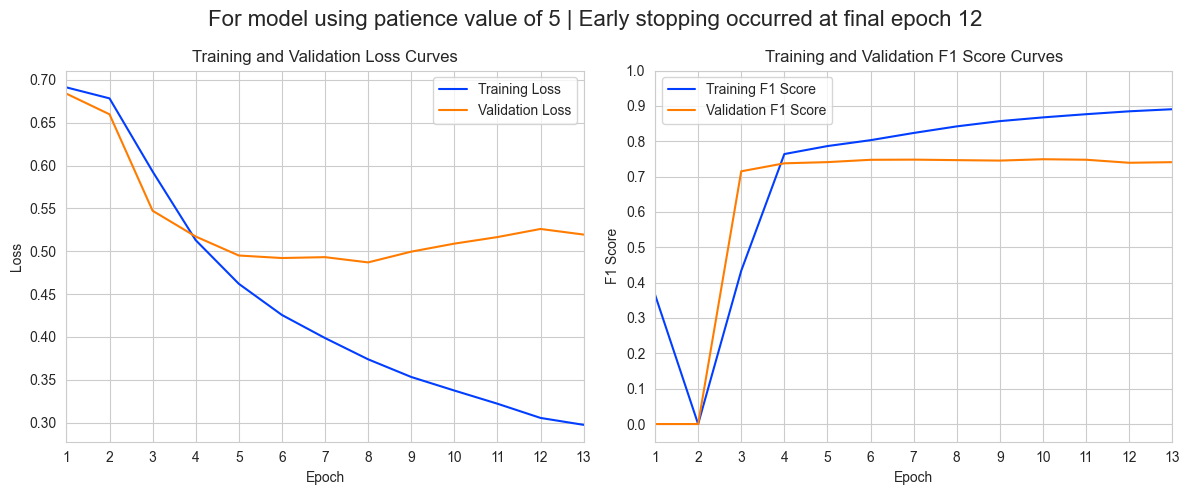

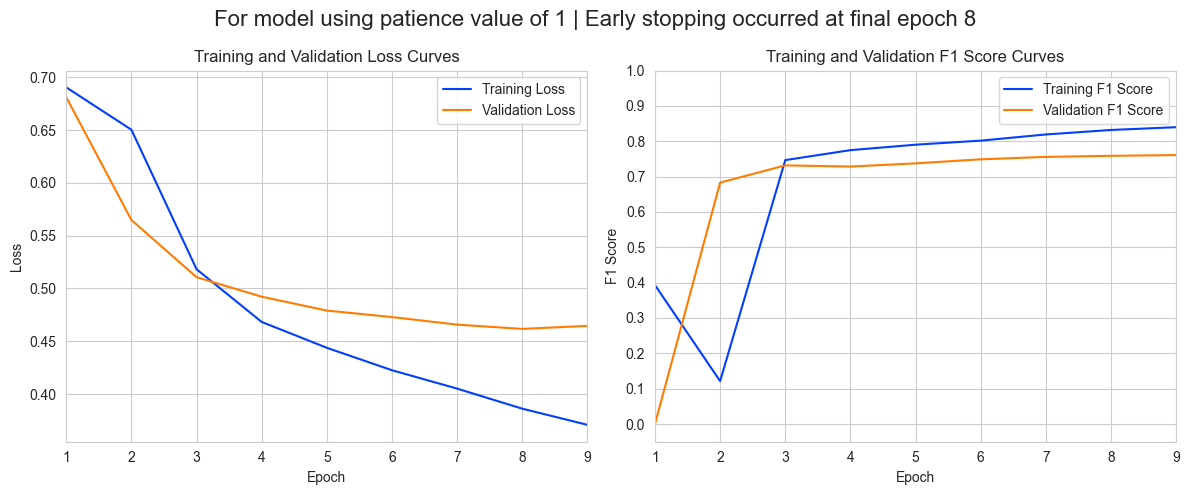

In [19]:
# Define super title for patience value of 5
suptitle_5 = "For model using patience value of 5"
if final_epoch_5 < NUM_EPOCHS: 
    suptitle_5 += f" | Early stopping occurred at final epoch {final_epoch_5}"

# Plot the curves for patience value of 5
loss_f1_score_curve(train_losses_5, val_losses_5, train_f1_scores_5, val_f1_scores_5, suptitle_5)

# Provide space between plots
print()

# Define super title for patience value of 1
suptitle_1 = "For model using patience value of 1"
if final_epoch_1 < NUM_EPOCHS: 
    suptitle_1 += f" | Early stopping occurred at final epoch {final_epoch_1}"

# Plot the curves for patience value of 1
loss_f1_score_curve(train_losses_1, val_losses_1, train_f1_scores_1, val_f1_scores_1, suptitle_1)

# Evaluating Model Perforance

We plot the ROC curve and will find the AUC value. The model will be set to evaluation mode, gradient tracking will be disabled for inference, and we will use the model with a patience value of 1 to get y prediction probabilities. We will compute the ROC curve and calculate the AUC score, and then we will form the curve.

We end up with an adequate-looking ROC curve and an AUC score of in the 0.8 to 0.9 range, which will depend slightly on randomness but will be consistent across multiple attempts. This is considered to be a good AUC score for binary classification.

We will also calculate the precision, recall, accuracy, Matthew's correlation coefficient, Cohen's Kappa, and specificity. We can see these values are adequate but could still be better.

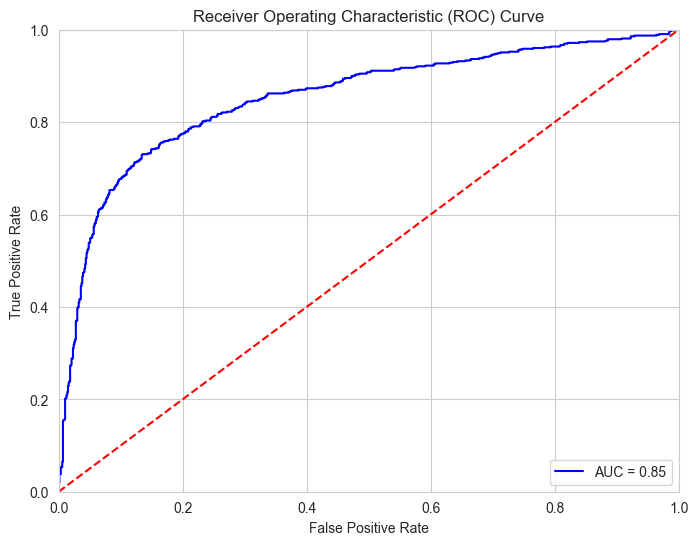

In [20]:
# Perform inference without gradient tracking
with torch.no_grad():
    # Set the model to evaluation mode
    model_1.eval()
    # Get predicted probabilities by applying sigmoid function to model outputs
    y_pred_probs = torch.sigmoid(model_1(X_val)).cpu().numpy()

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_val.numpy(), y_pred_probs[:, 1])
# Compute AUC score
auc = roc_auc_score(y_val.numpy(), y_pred_probs[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="b", label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], "r--") # Diagonal reference line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [21]:
# Caculate the precision, recall, accuracy, Matthew's correlation coefficient, Cohen's Kappa, and specificity
# Get y pred from y_pred_probs
y_pred = np.argmax(y_pred_probs, axis=1)

# Precision
precision = precision_score(y_val, y_pred)

# Recall
recall = recall_score(y_val, y_pred)

# Accuracy
accuracy = accuracy_score(y_val, y_pred)

# Matthew's correlation coefficient
mcc = matthews_corrcoef(y_val, y_pred)

# Cohen's Kappa
kappa = cohen_kappa_score(y_val, y_pred)

# Specificity
TN = ((y_val == 0) & (y_pred == 0)).sum() # True Negatives
FP = ((y_val == 0) & (y_pred == 1)).sum() # False Positives
specificity = TN / (TN + FP)

# Display values
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Specificity: {specificity:.4f}")

Precision: 0.7657
Recall: 0.7559
Accuracy: 0.7996
Matthews Correlation Coefficient (MCC): 0.5884
Cohen's Kappa: 0.5884
Specificity: 0.8314


# Continuing to Improve the Model

Beyond early stopping that was already performed, several strategies can be employed to potentially enhance the performance of the BiLSTM model. One approach is to experiment with different architectures by adjusting the number of hidden units and layers. Increasing the number of hidden units can allow the model to capture more complex patterns in the data, while adding more layers can enable it to learn hierarchical representations. Additionally, fine-tuning hyperparameters such as the learning rate can significantly impact the model's convergence and generalization ability.

Furthermore, incorporating regularization techniques such as dropout or weight decay can help prevent overfitting by introducing noise or penalizing large weights, respectively. 

Moreover, exploring different optimization algorithms beyond Adam might also yield improvements. Techniques like learning rate scheduling can also be beneficial.

Finally, data augmentation methods such as adding noise, perturbing input sequences, or generating synthetic samples can potentially increase the model's robustness and performance on the validation data and ultimately the test data. Experimentation across different data preprocessing techniques, feature engineering strategies, and incorporating domain-specific knowledge can also contribute to enhancing model performance.

# Predicting and Creating the Submission CSV

Finally, we will predict using the chosen model and the testing dataset that was prepared earlier. We will set the model to evaluation mode, send the testing data to the device, disable gradient-tracking, and find the predictions and convert them to an array. We will display the shape and first 10 predictions to confirm the output is in line with what is expected.

We will then make a dataframe for submission, using the `id` column we saved from earlier and the predictions we made. We will display this dataframe to confirm it is in line with what is expected.

We will then save the dataframe as a CSV to the "data" folder without indexing, and it will be ready for submission in Kaggle.

In [25]:
# Set the model to evaluation mode
model_1.eval()

# Move the test data to the device
X_test = X_test.to(device)

# Perform inference without gradient tracking
with torch.no_grad():
    # Make predictions
    y_pred = model_1(X_test.squeeze(1)).argmax(dim=1)
    
    # Convert predictions to numpy array
    predictions = y_pred.cpu().numpy()

# Show shape of predictions
print(f"Predictions shape: {predictions.shape}")
print(f"First 10 predictions: {predictions[:10]}")

Predictions shape: (3263,)
First 10 predictions: [1 1 1 1 1 0 0 0 0 0]


In [26]:
# Create a dataframe for submission
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "target": predictions
})

# Display the dataframe
display(submission_df)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,1


In [27]:
# Save the dataframe to a CSV file without including the index
submission_path = "../data/submission.csv"
submission_df.to_csv(submission_path, index=False)

# Summary and Conclusions

This notebook focuses on Natural Languagp Processing (NLP) using a Bidirectional Long Short-Term Memory (BiLSTM) neural network architecture to predict whether tweets correspond to real disasters. The notebook utilizes datasets from Kaggle and employs various data preprocessing techniques, including text cleaning and converting words to numeric vectors. The model is trained using PyTorch, and efforts are made to mitigate overfitting through early stopping. The model's performance is evaluated using metrics such as F1 score, ROC curve, and AUC score. Finally, predictions are made on the testing dataset, and a submission CSV file is created for Kaggle.

## Conclusions

Here is a list of conclusions based on different steps taken throughout the notebook:

1. **Data Preprocessing**: The data underwent cleaning processes such as removing duplicates and handling missing values. Text preprocessing techniques were done primarily using spaCy's `en_core_web_lg` model to convert text data to arrays of numerical vectors. Data is separated into X and y training, validation, and testing datasets, except there are no y values for the testing dataset. Datasets are converted into Torch tensors and into data loaders when needed.
2. **Model Architecture**: A BiLSTM neural network model was implemented using PyTorch, suitable for sequence-based tasks like NLP. Two models were trained with different patience values for early stopping to mitigate overfitting.
3. **Model Training**: Training was conducted using a custom function that iteratively updates the model parameters while monitoring loss and F1 score. Early stopping was implemented to prevent overfitting.
4. **Model Evaluation**: The trained model's performance was evaluated using various metrics including F1 score, ROC curve, and AUC score. While the AUC score indicated good performance, some metrics still indicated that improvement could be made.
5. **Future Improvements**: Suggestions for enhancing model performance were made including experimenting with different architectures, hyperparameter tuning, incorporating regularization techniques, and exploring alternative optimization algorithms.
6. **Submission**: Predictions were made on the testing dataset, and a submission dataframe and CSV file was prepared for Kaggle competition, showcasing the model's practical application.

Overall, this notebook explored using a BiLSTM neural network for NLP to predict real disasters from tweets. The notebook employed data pre-processing, PyTorch model training with early stopping, and various evaluation metrics. While the model showed promise (good AUC score), there's room for improvement through architecture exploration, hyperparameter tuning, and alternative techniques. Finally, the model was used to form a submission CSV file.